<a href="https://colab.research.google.com/github/vanecornejo/EDP-II/blob/main/Richardson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Ecuación de calor: método de Richardson**


Resolvemos la ecuación de calor
$$ \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad x\in(0,1),\ t>0 $$
con condiciones de contorno de Dirichlet
$$ u(0,t)=u(1,t)=0 $$
y condición inicial
$$ u(x,0)=\sin(\pi x) $$
Con solución exacta:
$$ u(x,t)=e^{-\pi^2 t}\sin(\pi x) $$

In [14]:
# Importamos librerías
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [15]:
def f(x):
    return np.sin(np.pi*x)

In [16]:
A = sp.Matrix([[3,-1, 0, 0, 0, 0, 0, 0, 0],
              [-1, 3,-1, 0, 0, 0, 0, 0, 0],
              [0, -1, 3,-1, 0, 0, 0, 0, 0],
              [0, 0, -1, 3,-1, 0, 0, 0, 0],
              [0, 0, 0, -1, 3,-1, 0, 0, 0],
              [0, 0, 0, 0, -1, 3,-1, 0, 0],
              [0, 0, 0, 0, 0, -1, 3,-1, 0],
              [0, 0, 0, 0, 0, 0, -1, 3,-1],
              [0, 0, 0, 0, 0, 0, 0, -1, 3,]])

**Ejercicio 1:** Codificar la matriz A de manera más simple.

In [17]:
# Parámetros
N = 9
x_internal = np.linspace(1/(N+1), N/(N+1), N)
h = 1.0 / (N + 1)
r = 0.4
k = r * h**2

In [18]:
diag_main = 3 * np.ones(N)
diag_off = -1 * np.ones(N - 1)
A_np = np.diag(diag_main) + np.diag(diag_off, -1) + np.diag(diag_off, 1)
A_np

array([[ 3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  3., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  3., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  3., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  3., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  3., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  3.]])

In [19]:
b = sp.Matrix([f(0.1), f(0.2), f(0.3), f(0.4), f(0.5), f(0.6), f(0.7), f(0.8), f(0.9)])

**Ejercicio 2:** Definir las entradas de b de manera más simple (quizás con un bucle).

In [20]:
b = sp.Matrix([f(x) for x in x_internal])
b

Matrix([
[0.309016994374947],
[0.587785252292473],
[0.809016994374947],
[0.951056516295154],
[              1.0],
[0.951056516295154],
[0.809016994374947],
[0.587785252292473],
[0.309016994374948]])

In [21]:
def richardson_1(A, b, j):
    b_1 = b
    for i in range(j+1):
        sol = A.LUsolve(b_1)
        b_1 = sol
        _ = None #Para que no imprima resultados parciales
    return b_1

In [22]:
richardson_1(A, b, 3)

Matrix([
[0.212692337894623],
[0.404564867841463],
[  0.5568357697548],
[0.654599706821597],
[0.688286863720354],
[0.654599706821597],
[  0.5568357697548],
[0.404564867841463],
[0.212692337894623]])

In [23]:
def richardson(A, b, j):
    S = []
    b_1 = b.copy()

    for i in range(j+1):
        S.append(np.array(b_1, dtype=float).reshape(-1))  # vector fila
        sol = A.LUsolve(b_1)
        b_1 = sol

    return np.array(S)   # matriz resultado

### Método implícito Richardson
El sistema en cada paso es  
$$(I + \Delta t A)\mathbf{u}^{n+1} = \mathbf{u}^n$$
Reescrito como punto fijo:
$$\mathbf{u}^{n+1} = \mathbf{u}^n - \Delta t A \mathbf{u}^{n+1}$$
→ iteramos Richardson:
$$ \mathbf{v}_{k+1} = \mathbf{u}^n - \Delta t A \mathbf{v}_k$$

**Ejercicio 4:** Graficar para un valor particular de t > 0 y comparar contra la gráfica de la solución exacta.

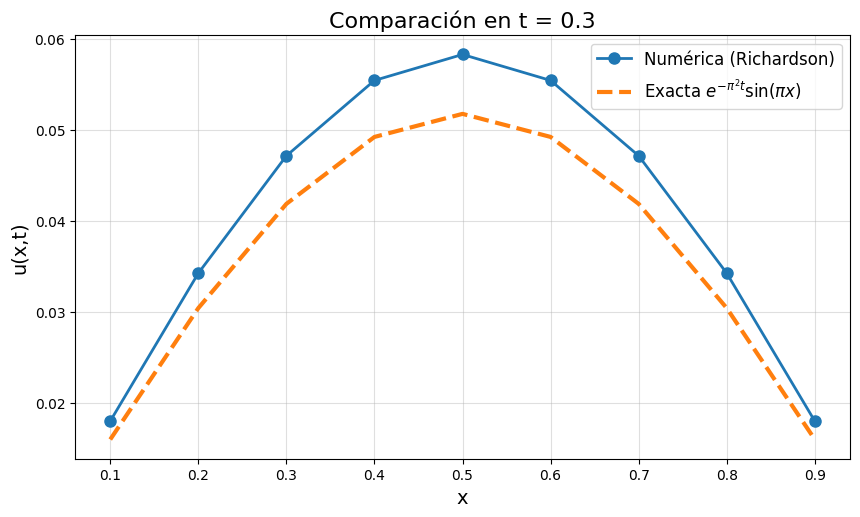

In [24]:
from scipy.linalg import lu_factor, lu_solve

def richardson_implicito(M, u0, steps):
    lu, piv = lu_factor(M)
    u = u0.copy().reshape(-1)
    U = np.zeros((steps+1, len(u)))
    U[0] = u
    for n in range(1, steps+1):
        u = lu_solve((lu,piv), u)
        U[n] = u
    return U

L = np.diag([2]*N) + np.diag([-1]*(N-1), -1) + np.diag([-1]*(N-1), 1)
M = np.eye(N) + r * L
t_objetivo_plot = 0.3

j = int(t_objetivo_plot / k)
if j < 1:
    j = 1

b_np = np.array(b).astype(float)
U = richardson_implicito(M, b_np, j)
t_objetivo = t_objetivo_plot

t_objetivo = 0.3
n_obj = int(t_objetivo/k)

u_exacta = np.exp(-np.pi**2 * t_objetivo) * np.sin(np.pi * x_internal)

plt.figure(figsize=(10,5.5))
plt.plot(x_internal, U[n_obj], 'o-', label='Numérica (Richardson)', markersize=8, lw=2)
plt.plot(x_internal, u_exacta, '--', label=r'Exacta $e^{-\pi^2 t}\sin(\pi x)$', lw=3)
plt.title(f'Comparación en t = {t_objetivo}', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x,t)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.show()

**Ejercicio 5:**¿Es necesario resolver el sistema de 9 x 9 o podemos hacer una simplificación?

 Sí, el esquema implícito acopla todos los nodos, con el método Richardson no factorizamos ni inviertimos la matriz en ningún momento, es mucho más eficiente que LU.

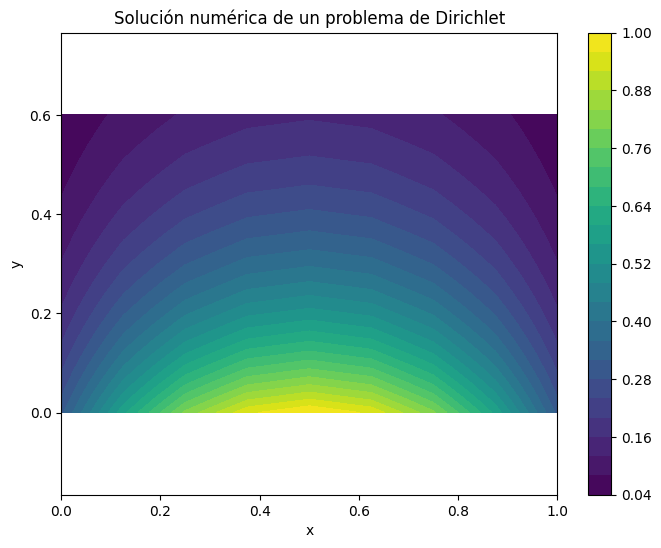

In [25]:
j = 20 # Número de pasos en el tiempo
U = richardson(A, b, j)

x = np.linspace(0, 1, 9) #Número de nodos internos en X
y = np.linspace(0, 0.6, j+1) #Debe coincidir con el tamaño de j por k (tiempo)
X, Y = np.meshgrid(x, y)

# Mapa de colores
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, U, levels=25, cmap=cm.viridis)
plt.colorbar(contour)
plt.title('Solución numérica de un problema de Dirichlet')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

La gráfica muestra cómo se distribuye el calor dentro de un rectángulo.
En la parte de abajo hay una zona caliente en el centro y, en los bordes laterales y en la parte de arriba, es zona fría. Las reegiones cercanas al centro tienen una temperatura más elevada que las regiones alejadas.

Entonces, la solución numérica nos muestra bien el comportamiento físico esperado.

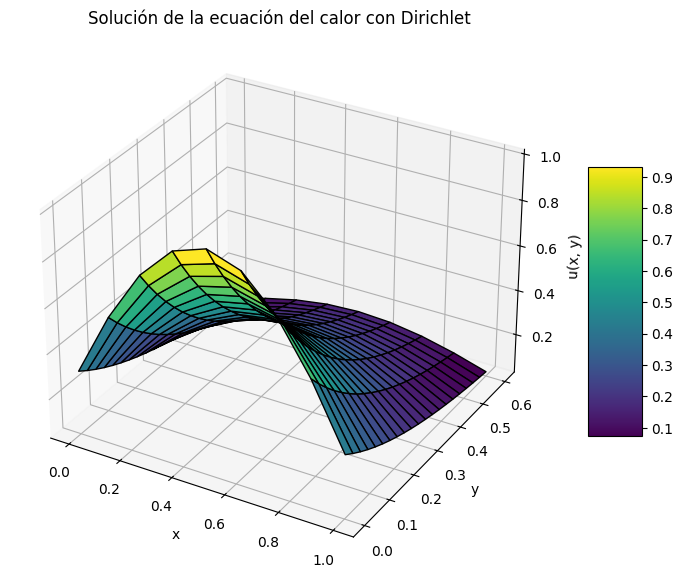

In [26]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, U, cmap=cm.viridis, edgecolor='k')
ax.set_title('Solución de la ecuación del calor con Dirichlet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Podemos ver la misma gráfica anterior que estaba en 2D, pero ahora de manera tridimensional, representando lo mismo con la zona caliente al centro en uno de los bordes.

**Ejercicio 6:** Hay un ligero detalle con la precisión de estas gráficas, ¿cuál?

En la parte del borde de arriba la temperatura debería ser exactamente 0, o sea, morado oscuro total. Pero en las gráficas no llega a ser morado total puro, queda una rayita muy finita azul, como si ahí todavía quedara algo de calor.